<a href="https://colab.research.google.com/github/unburied/120-Data-Science-Interview-Questions/blob/master/Pumps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!pip install pandas_profiling
!pip install category_encoders

In [0]:
import pandas as pd
import numpy as np

import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [4]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/train_features.csv
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/train_labels.csv
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/test_features.csv
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/sample_submission.csv

--2019-07-24 04:45:38--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/train_features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20054664 (19M) [text/plain]
Saving to: ‘train_features.csv.1’

train_features.csv. 100%[===================>]  19.12M   125MB/s    in 0.2s    

2019-07-24 04:45:38 (125 MB/s) - ‘train_features.csv.1’ saved [20054664/20054664]

--2019-07-24 04:45:39--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/train_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP req

In [0]:
import pandas_profiling as pp

##Fetch

In [0]:
#load dataframes
X = pd.read_csv('train_features.csv')
Y = pd.read_csv('train_labels.csv')

#Drop id's
Y = Y.status_group

In [0]:
#pp.ProfileReport(X)

##Baseline

In [8]:
#Split data
X_train, X_val, y_train, y_val = train_test_split(X, Y,random_state = 42,stratify = Y)
    
#Baseline
y_train.value_counts(normalize = True)

functional                 0.543075
non functional             0.384242
functional needs repair    0.072682
Name: status_group, dtype: float64

In [9]:
#get nums from df
numericals = X.select_dtypes('number').columns.to_list()
print(numericals)

['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']


In [10]:
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 350)
model.fit(X_train[numericals],y_train)
model.score(X_val[numericals], y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.5484848484848485

In [0]:
#plot coefficent values for each label
fig = plt.figure(figsize = (30,5))

ax = fig.add_subplot(131)
coeffs = pd.Series(model.coef_[0], numericals)
ax = coeffs.sort_values().plot.barh()
ax.set_title(model.classes_[0], color = 'g')

ax1 = fig.add_subplot(132)
coeffs = pd.Series(model.coef_[1], numericals)
ax1 = coeffs.sort_values().plot.barh()
ax1.set_title(model.classes_[1], color = 'y')

ax2 = fig.add_subplot(133)
coeffs = pd.Series(model.coef_[2], numericals)
ax2 = coeffs.sort_values().plot.barh()
ax2.set_title(model.classes_[2], color = 'r')

plt.show();

It looks like longitude and region code have some of the largest effects on the model based on the coefficients

##PreProcessing


In [0]:
def get_elevations(x):
#store each region and gps height in dict
  elevations = {}
  for region in x.region.unique():
    elevations[region] = x[x.region == region]['gps_height'].median()

#These looks to be the problem areas. The median values for these regions should not be zeo
  zero_regions = ['Dodoma', 'Kagera', 'Mbeya', 'Mwanza', 'Shinyanga', 'Tabora']

#I looked up the elevations and imputed the data
  elevations['Dodoma'] = 1118
  elevations['Kagera'] = 1500
  elevations['Mbeya'] = 1700
  elevations['Mwanza'] = 1140
  elevations['Shinyanga'] = 1128
  elevations['Tabora'] = 1191

#Use new values to clean zeroes in df based on imputed values
  for key in elevations:
    if key in zero_regions:
      x.loc[x.region == key, 'gps_height'] = elevations[key]
  
  return x

In [0]:
def get_dates(x):
  #reassgin as datetime object
  x.date_recorded = pd.to_datetime(x.date_recorded,
                                   infer_datetime_format= True)
  
  #split values and add to df
  x['year_rec'] = x.date_recorded.dt.year
  x['month_rec'] = x.date_recorded.dt.month
  x['day_rec'] = x.date_recorded.dt.day
  
  #drop dates(not working with standard scaler?)
  x = x.drop('date_recorded', axis = 1)
  
  return x

In [0]:
#Impute population based on current data
def get_pops(x):  
  #These are HALF the current estimates for population
  region_pops = {'Dodoma' : 1050000, 'Kagera' : 1229000,
                 'Mbeya' : 135000, 'Tabora': 113500}

  #Get means for regions using estimates and the std of the set for consistency
  for region,pop in region_pops.items():
    size = x.loc[x.region == region, 'population'].size
    mean =   pop / size
    std = x.population.std()

  #function will use Gaussian distribution to impute value at each location
    def pop_imputer(n):
      random = np.random.normal()
      impute = mean + (random * std)

      #Ensure value is not less than zero, if so rerun func
      if impute < 0:
        pop_imputer(n)
      else:
        return int(impute) + n

    x.loc[x.region == region, 'population'] = x.loc[x.region == region,
                                               'population'].apply(pop_imputer)

  return x

In [0]:
def coordinates(x):
  
#eliminate null island values
  x['latitude'] = x['latitude'].replace(-2e-08, 0)

  #These locations contain ALL zero values for longitude
  locations = {'Magu' : 33.4444, 'Geita' : 32.2314, 'Bariadi' : 33.9833}
  
  for key,val in locations.items():
    x.loc[x.lga == key, 'longitude'] = val
  
  return x

In [0]:
def clean(df):
  x = df.copy()
  
#Clean zeroes/impute with mode
  x['construction_year'] = x.construction_year.replace(0, np.nan)
  x.construction_year = np.where(x.construction_year.isnull(),
                                 x.construction_year.mode(),
                                 x.construction_year)  

#reassign date values and impute elevation, population, and longitude data
  x = get_dates(x)
  x = get_elevations(x)
  x = get_pops(x)
  x = coordinates(x)

#drop items both high card and duplicates
  dropping = ['quantity_group', 'recorded_by','subvillage', 'wpt_name',
              'management_group']  
  x = x.drop(dropping, axis = 1)

#reassign bool values
  x['permit'] = np.where(x.permit == True , 1,0)
  x['public_meeting'] = np.where(x.public_meeting == True , 1,0)

  return x


In [0]:
#clean, encode, and scale data
def encode_df(df):
  X = df.copy()
  
    #encode objects
  for col in X.select_dtypes('object').columns.tolist():
    #One hot encode low card data
    if len(X[col].unique()) <=10:
      encode = ce.OneHotEncoder(use_cat_names=True)
      X = X.join(encode.fit_transform(X[col].astype('str')))
      X = X.drop(col, axis = 1)
    #Label encode high card data  
    else:
      le = LabelEncoder()
      X[col] = le.fit_transform(X[col].astype('str')) 

  #Scale data
  scaled = StandardScaler().fit_transform(X)
  
  #Ensure columns are maintained
  X = pd.DataFrame(scaled, columns = X.columns)
  
  return X

In [0]:
def dropNA(X, **kwargs):
  #if a target vector is supplied, store a copy in Y
  if 'y' in kwargs:
    Y = kwargs['y'].copy()
    
    #Combine data for a consistent drop
    X = X.join(Y)

    #drop NANs
    X = X.dropna()

    #Split data
    Y = X.pop('status_group')
  
    return X,Y
  else:
    X = X.dropna()
    
    return X

In [0]:
def split_data(X,Y):  
  #Split data
  X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                              random_state = 42,stratify = Y)
  
  return [X_train, X_val, y_train, y_val]

In [0]:
#Pipeline to encode, scale, split 
#if no kwargs are supplied, will only transform data
#y = target vector - is optional but required to run split function
#dropNA = True - dropNA for df or both df and y
#split_data = True - perform train test split and return list of split data

def pipeline(df, **kwargs):
  target_supplied = False
  
  #copy and transform data
  x = clean(df)
  
  #check kwargs data for functions inputs
  function = {'dropNA': False, 'split_data': False,
              'impute': False, 'encode' : False}
  for key in function:
    if key in kwargs and kwargs[key]:
      function[key] = True
  
  #if a target vector is supplied, store a copy in Y
  if 'y' in kwargs:
    Y = kwargs['y'].copy()
    target_supplied = True
    
  #implement simple imputer if called
  if function['impute']:
    si = SimpleImputer()
    imputed = si.fit_transform(x)
    x = pd.DataFrame(imputed, columns = x.columns)
    
  #encode categorical data
  if function['encode']:
    x = encode_df(x)
    
  #if dropNA is requested, run function dropNA with target vector
  if function['dropNA'] and target_supplied:
    x,Y = dropNA(x, y = Y)
  #if dropNA is requested with no target data, just update X
  elif function['dropNA'] and not target_supplied:
    x = dropNA(x)
    
  #if split data is requested, run function split_data(requires target to be true)
  if function['split_data'] and target_supplied:
    return split_data(x,Y)
  
  if target_supplied:
    return x,Y
  else:
    return x

##Preliminary Models

In [0]:
#test and score each model
def model_score(model, data):
  X_train = data[0] 
  X_val = data[1]
  y_train = data[2]
  y_val = data[3]
  
  model.fit(X_train,y_train)
  y_pred = model.predict(X_val)
  
  return accuracy_score(y_val, y_pred)

In [0]:
tt = pipeline(X)

In [44]:
tt.isna().sum()

id                           0
amount_tsh                   0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
num_private                  0
basin                        0
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                4193
public_meeting               0
scheme_management         3877
scheme_name              28166
permit                       0
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
source                       0
source_type                  0
source_class                 0
waterpoi

In [46]:
#run dfs through pipeline
data = pipeline(X, y = Y, encode = True, dropNA = True, split_data = True)

#instantiate models
#dt = DecisionTreeClassifier()
#gbm = GradientBoostingClassifier()
#knn = KNeighborsClassifier()
rfc = RandomForestClassifier()

#get and print scores
#print(f'Tree - {model_score(dt, data)}')
#print(f'Boost - {model_score(gbm, data)}')
#print(f'Neighbor - {model_score(knn, data)}')
print(f'Forest - {model_score(rfc, data)}')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Forest - 0.7968376006382825


Its looks like Random Forest will give us a good score right from the start. 

##Feature Engineering

In [0]:
importance = pd.Series(rfc.feature_importances_, data[0].columns)

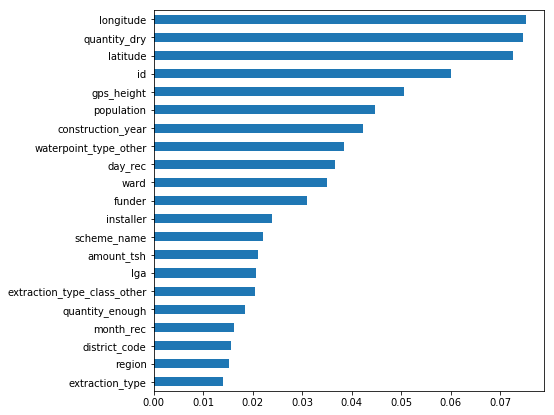

In [51]:
fig = plt.figure(figsize = (7,7))
importance.sort_values(ascending = True)[86:].plot.barh();

In [27]:
X.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


##Submission


In [0]:
#fetch test data for submission
test = pd.read_csv('test_features.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [0]:
#clean and preprocess data
test = pipeline(test, dropNA = True)
X_pip, Y = pipeline(X, y = Y, dropNA = True)

In [0]:
forest = RandomForestClassifier(n_estimators=100)

forest.fit(X_pip, Y)
y_pred = forest.predict(test)

In [0]:
from google.colab import files

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-01.csv', index=False)


files.download('submission-01.csv')